In [62]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
from skimage.color import rgb2gray

In [63]:
lenna = rgb2gray(skio.imread('Lenna.png'))
dora = rgb2gray(skio.imread('dora.png'))
platform = rgb2gray(skio.imread('platform.png'))
hibiscus = skio.imread('hibiscus.png')
einstein = skio.imread('einstein2.png')
balloon = skio.imread('balloon.png')

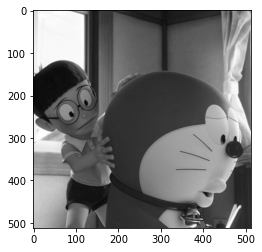

In [64]:
plt.imshow(dora, cmap="gray")
plt.show()

(1) Singular Value Decomposition (SVD)

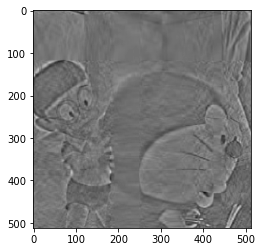

In [71]:
# Use the SVD function to compute SVD of the image
u, s, vh = np.linalg.svd(dora, full_matrices=True)
r, c = lenna.shape
# Generate a rank-k approximation image
img = np.zeros((r, c))
uh = np.array(u).T

k = 40

for i in range(0, k):
    img = np.add(img, np.matmul(np.array([uh[i]]).T, np.array([vh[i]])))

plt.imshow(img, cmap="gray")
plt.show()

(2) Discrete Fourier Transform (DFT)

(3) Haar Transform

(4) Walsh Transform